In [1]:
import torch
import os
import nibabel as nib
import matplotlib.pyplot as plt
import json

from Steerable.Segmentation.display import display_segmentation_map

In [2]:
class Decathlon(torch.utils.data.Dataset):
    def __init__(self, data_path, image_transform = None, target_transform = None) -> None:

        self.image_transform = image_transform
        self.target_transform = target_transform
        
        with open(os.path.join(data_path, 'dataset.json'), 'r') as file:
            files = json.load(file)['training']
        self.image_files = [os.path.join(data_path, location['image']) for location in files]
        self.target_files = [os.path.join(data_path, location['label']) for location in files]
        
        self.n_samples = len(self.image_files)

    def __getitem__(self, index):
        image_file = self.image_files[index]
        target_file = self.target_files[index]
        assert os.path.basename(image_file) == os.path.basename(target_file)

        image = torch.from_numpy(nib.load(image_file).get_fdata())
        image = image.reshape(*image.shape[:3], -1).permute(3,0,1,2)
        target = torch.from_numpy(nib.load(target_file).get_fdata())
        
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return self.n_samples

def get_datasets(data_path) -> dict:
    dataset = Decathlon(data_path)
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])
    
    
    return {'train' : train_dataset, 'val': val_dataset, 'test' : test_dataset}


torch.Size([1, 512, 512, 288])
torch.Size([512, 512, 288])


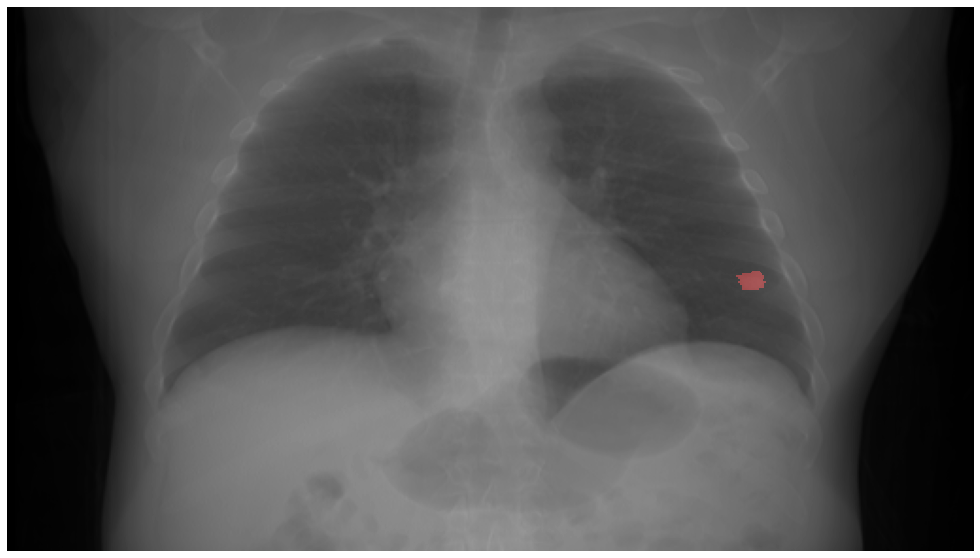

In [10]:
dataset = get_datasets('/mnt/d/UCHICAGO/Academic/Projects/Research Projects/Steerable Segmenter/data/Decathlon/Lung')['train']
index = torch.randint(0, len(dataset), (1,)).item()
image, target = dataset[index]

print(image.shape)
print(target.shape)

dim=1
target_plot = torch.rot90(torch.max(target, dim=dim)[0].type(torch.int), k=1)
image_plot = torch.rot90(torch.mean(image, dim=(0,dim+1)))
plt.figure(figsize=(40,10))
display_segmentation_map(target_plot, colorbar=False)
plt.imshow(image_plot, cmap='gray', alpha=0.6)
plt.show()

In [11]:
def get_max_size(data_path):
    datasets = get_datasets(data_path)
    size = []
    for mode in datasets:
        print(mode, '...')
        for index, (image, target) in enumerate(datasets[mode]):
            assert image.shape[1:] == target.shape
            size.append(list(image.shape))
            print(torch.unique(target))
            print(f'{index} / {len(datasets[mode])}', end='\r')
    size_tensor = torch.tensor(size)
    return torch.max(size_tensor[:,1]).item(), torch.max(size_tensor[:,2]).item(), torch.max(size_tensor[:,3]).item()

In [12]:
get_max_size('/mnt/d/UCHICAGO/Academic/Projects/Research Projects/Steerable Segmenter/data/Decathlon/Lung')

train ...


: 